In [1]:
# Parameters
data_url = "https://github.com/mmore500/hereditary-stratigraph-concept/blob/89982d838379d5a26aabfef6889e1262fc3b289f/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_randomselection_seed7_pop100_mut.01_snapshot_5000.csv.gz"


In [2]:
import endomill
from nbmetalog import nbmetalog as nbm


In [3]:
nbm.print_metadata()


context: ci
hostname: b734aff1db69
interpreter: 3.8.12 (default, Jan 15 2022, 18:39:47)  [GCC 7.5.0]
nbcellexec: 3
nbname: phylogeny_reconstruction_mill
nbpath: /opt/hereditary-stratigraph-concept/binder/phylogenetic-inference/phylogeny_reconstruction_mill.ipynb
revision: null
session: 575cb2e2-c738-4119-9ba0-c121ed016f62
timestamp: 2022-03-07T17:47:04Z00:00


IPython==7.16.1
keyname==0.4.1
yaml==5.3.1
endomill==0.1.3
nbmetalog==0.2.6
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.3.0
json==2.0.9
ipykernel==5.5.3


In [4]:
data_urls = [
    'https://github.com/mmore500/hereditary-stratigraph-concept/blob/89982d838379d5a26aabfef6889e1262fc3b289f/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_lexicaseselection_seed110_pop165_mut.01_snapshot_500.csv.gz',
    'https://github.com/mmore500/hereditary-stratigraph-concept/blob/89982d838379d5a26aabfef6889e1262fc3b289f/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_randomselection_seed7_pop100_mut.01_snapshot_5000.csv.gz',
    'https://github.com/mmore500/hereditary-stratigraph-concept/blob/89982d838379d5a26aabfef6889e1262fc3b289f/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_sharingselection_seed10_pop100_mut.01_snapshot_5000.csv.gz',
    'https://github.com/mmore500/hereditary-stratigraph-concept/blob/89982d838379d5a26aabfef6889e1262fc3b289f/binder/phylogenetic-inference/a=pairwise_mrca_estimates+source=nk_tournamentselection_seed140_pop100_mut.01_snapshot_5000.csv.gz',
]

endomill.instantiate_over(
    parameter_packs=[
        {'data_url': data_url}
        for data_url in data_urls
    ],
)


detected executing.endomill.ipynb file
skipping instantiate_over


In [5]:
#define papermil parameters
data_url: str


In [6]:
import alifedata_phyloinformatics_convert as apc
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
import itertools as it
from keyname import keyname as kn
from matplotlib import pyplot as plt
import numpy as np
from os.path import basename
import pandas as pd
import sys
from teeplot import teeplot as tp
from tqdm import tqdm


In [7]:
nbm.print_metadata()


context: ci
hostname: b734aff1db69
interpreter: 3.8.12 (default, Jan 15 2022, 18:39:47)  [GCC 7.5.0]
nbcellexec: 7
nbname: phylogeny_reconstruction_mill
nbpath: /opt/hereditary-stratigraph-concept/binder/phylogenetic-inference/phylogeny_reconstruction_mill.ipynb
revision: null
session: 575cb2e2-c738-4119-9ba0-c121ed016f62
timestamp: 2022-03-07T17:47:05Z00:00


IPython==7.16.1
endomill==0.1.3
ipykernel==5.5.3
ipython_genutils==0.2.0
json==2.0.9
keyname==0.4.1
logging==0.5.1.2
nbmetalog==0.2.6
re==2.2.1
yaml==5.3.1
zmq==22.3.0
Bio==1.79
alifedata_phyloinformatics_convert==0.5.0
matplotlib==3.3.2
numpy==1.21.5
pandas==1.1.2
teeplot==0.2.0


In [8]:
df = pd.read_csv(
    f'{data_url}?raw=true',
    compression='gzip',
)

nbm.print_dataframe_synopsis(df)

data_filename = basename(data_url)

print(data_filename)


digest: 4904c4d5148631dc3981e0cfd55f80f729e1fe5eb76c610cb3e1b04ae88a4c80
manifest:
  Column Configuration: '                              18#     ex., actual_bits=63+actual_strata=63+bits_error=-1+differentia=1+policy=TaperedDepthProportionalResolution+resolution=31+target_bits=64'
  Differentia Bit Width: '                             3#      ex., 1'
  Generation Of MRCA Lower Bound (inclusive): '        65#     ex., 4736'
  Generation Of MRCA Upper Bound (exclusive): '        44#     ex., 5000'
  Generation of Taxon Compared From: '                 4#      ex., 5000'
  Generation of Taxon Compared To: '                   4#      ex., 5001'
  MRCA Bound Confidence: '                             3#      ex., 0.96875'
  Rank of Earliest Detectable Mrca With: '             6#      ex., 512'
  Stratigraphic Column Actual Num Retained Strata: '   11#     ex., 63'
  Stratigraphic Column Expected Retained Bits: '       12#     ex., 63'
  Stratigraphic Column Expected Retained Bits Error: ' 1

In [9]:
endomill.add_instance_outpath(
    f'a=phylogeny_reconstruction+source={kn.unpack(data_filename)["source"]}.endomill.ipynb'
)


In [10]:
df['Treatment'] = df.apply(
    lambda row: kn.pack({
        'target': row['Stratigraphic Column Target Retained Bits'],
        'differentia': row['Differentia Bit Width'],
        'policy': row['Stratum Retention Policy'],
    }),
    axis=1,
)


In [11]:
max_gen = df['Generation of Taxon Compared From'].max()


In [12]:
def create_distance_matrix(df):
    assert len(df['Treatment'].unique() == 1)

    counter = it.count()
    taxon_to_index = {
        taxon : next(counter)
        for taxon in df['Taxon Compared From'].unique()
    }
    label_list = sorted(
        [*df['Taxon Compared From'].unique()],
        key=lambda x: taxon_to_index[x],
    )
    assert len(label_list) == len(taxon_to_index)
    distance_dict = {
        (taxon_to_index[row['Taxon Compared From']], taxon_to_index[row['Taxon Compared To']]):
            row['Generation of Taxon Compared From']
            - row['Generation Of MRCA Lower Bound (inclusive)']/2
            - row['Generation Of MRCA Upper Bound (exclusive)']/2
        for __, row in df.iterrows()
    }

    distance_matrix = np.array([
        [
            float(distance_dict[(i, j)] + distance_dict[(j, i)])
            if i != j
            else 0.0
            for j in range(len(taxon_to_index))
        ]
        for i in range(len(taxon_to_index))
    ])

    return distance_matrix, label_list


In [13]:
def to_tril(matrix):
    return [
        row[:row_idx] + [0]
        for row_idx, row in enumerate(matrix.tolist())
    ]


In [14]:
mrca_dict = {
    (row['Taxon Compared From'], row['Taxon Compared To']):
        row['Generation Of MRCA Lower Bound (inclusive)']/2
        + row['Generation Of MRCA Upper Bound (exclusive)']/2
    for __, row in df.iterrows()
}
for __, row in df.iterrows():
    mrca_dict[(row['Taxon Compared From'], row['Taxon Compared From'])] \
        = row['Generation of Taxon Compared From']

def construct_tree(df, algorithm):
    assert len(df['Treatment'].unique() == 1)
    distance_matrix, label_list = create_distance_matrix(df)
    np.nan_to_num(distance_matrix, nan=max_gen+1, copy=False)
    dm = DistanceMatrix([*map(str, label_list)], to_tril(distance_matrix))
    tree = getattr(DistanceTreeConstructor(), algorithm)(dm)

    # fixup orign times
    for leaf1, leaf2 in it.product(tree.get_terminals(), tree.get_terminals()):
        mrca_node = tree.common_ancestor(leaf1, leaf2)
        calculated_mrca_time = mrca_dict[(int(leaf1.name), int(leaf2.name))]
        mrca_node.origin_time = calculated_mrca_time

    # fixup branch lengths
    tree.root.edge_length = tree.root.origin_time
    for node in tree.find_clades():
        for child in node.clades:
            child.edge_length = child.origin_time - node.origin_time

    # reroot tree
    new_root = min(tree.find_clades(), key=lambda node: node.origin_time)
    tree = Phylo.BaseTree.Tree(root=new_root)

    return tree


In [15]:
trees = {
    (treatment, algorithm): construct_tree(group, algorithm)
    for treatment, group in tqdm(df.groupby('Treatment'))
    for algorithm in ('nj', 'upgma')
}


  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:01<00:32,  1.89s/it]

 11%|█         | 2/18 [00:03<00:30,  1.89s/it]

 17%|█▋        | 3/18 [00:05<00:28,  1.90s/it]

 22%|██▏       | 4/18 [00:07<00:26,  1.90s/it]

 28%|██▊       | 5/18 [00:09<00:24,  1.90s/it]

 33%|███▎      | 6/18 [00:11<00:22,  1.91s/it]

 39%|███▉      | 7/18 [00:13<00:20,  1.90s/it]

 44%|████▍     | 8/18 [00:15<00:18,  1.90s/it]

 50%|█████     | 9/18 [00:17<00:17,  1.89s/it]

 56%|█████▌    | 10/18 [00:18<00:15,  1.88s/it]

 61%|██████    | 11/18 [00:20<00:13,  1.88s/it]

 67%|██████▋   | 12/18 [00:22<00:11,  1.87s/it]

 72%|███████▏  | 13/18 [00:24<00:09,  1.87s/it]

 78%|███████▊  | 14/18 [00:26<00:07,  1.88s/it]

 83%|████████▎ | 15/18 [00:28<00:05,  1.88s/it]

 89%|████████▉ | 16/18 [00:30<00:03,  1.88s/it]

 94%|█████████▍| 17/18 [00:32<00:01,  1.88s/it]

100%|██████████| 18/18 [00:33<00:00,  1.88s/it]

100%|██████████| 18/18 [00:33<00:00,  1.89s/it]

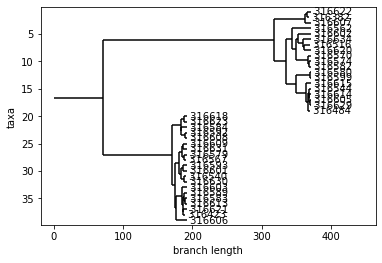

teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

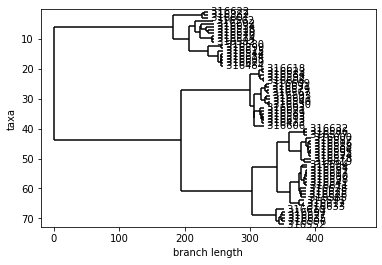

teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

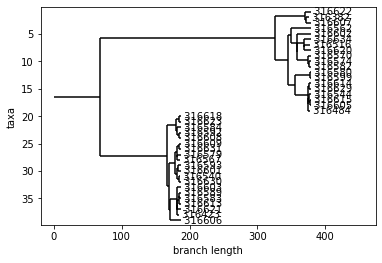

teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

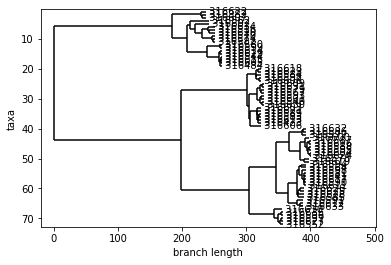

teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

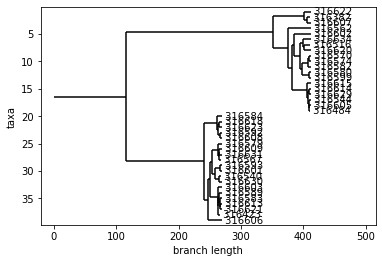

teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

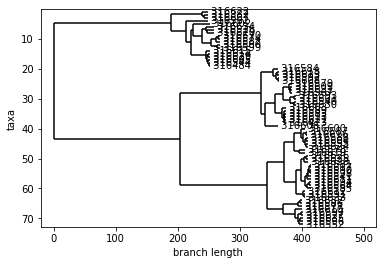

teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

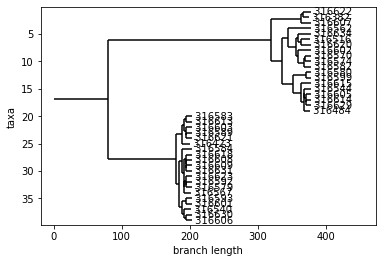

teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

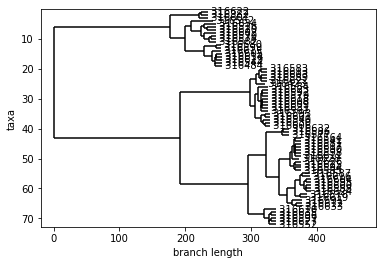

teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

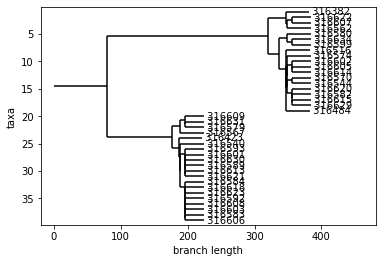

teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

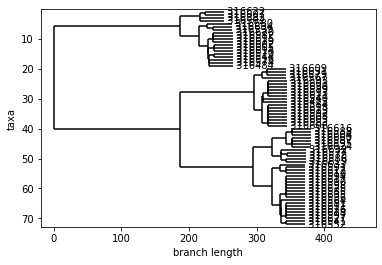

teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

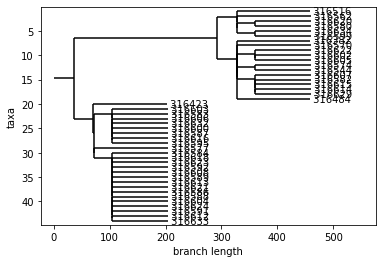

teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

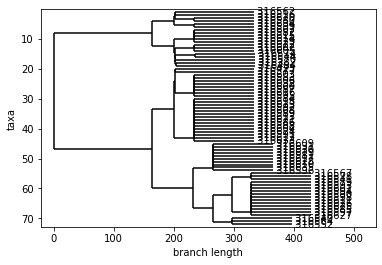

teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%1~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

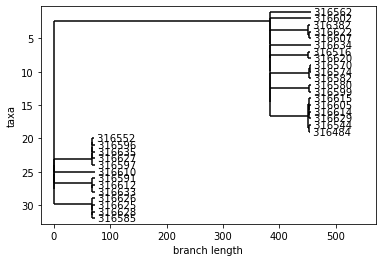

teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

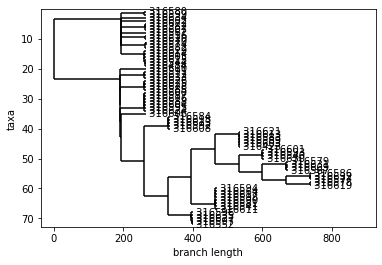

teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

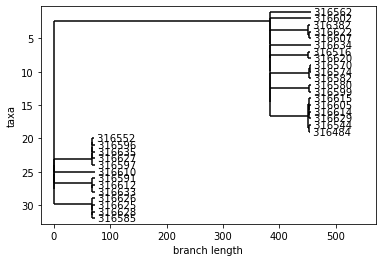

teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

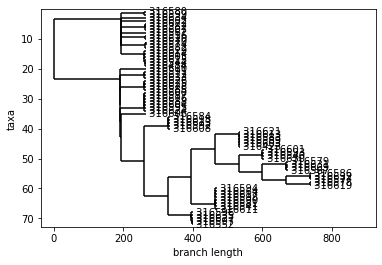

teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

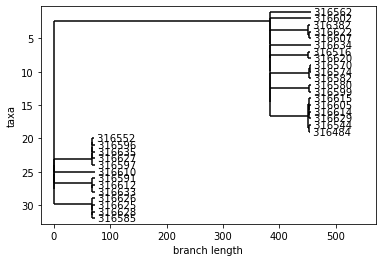

teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

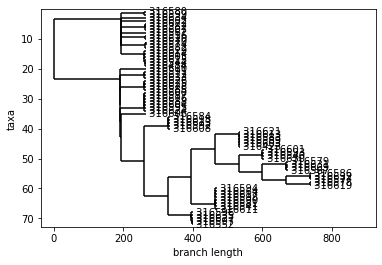

teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

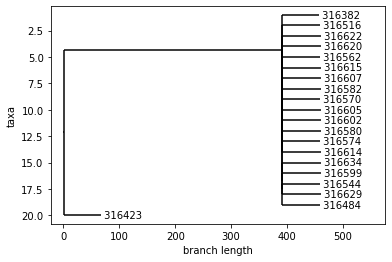

teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

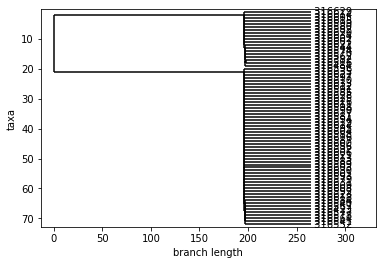

teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

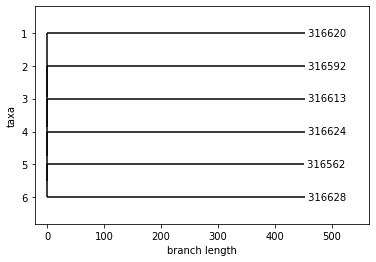

teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

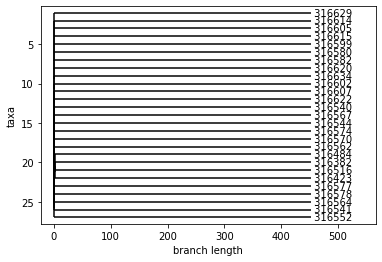

teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

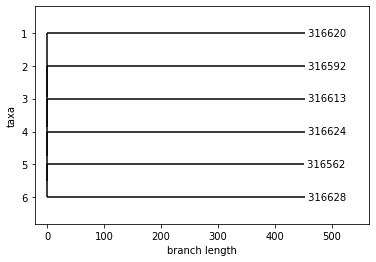

teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

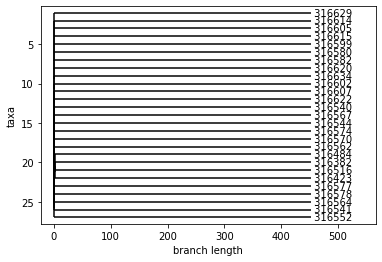

teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%64~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

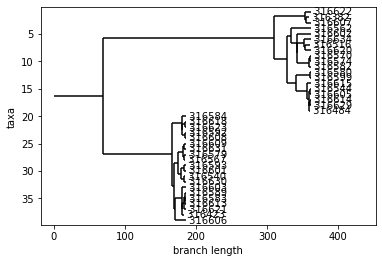

teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

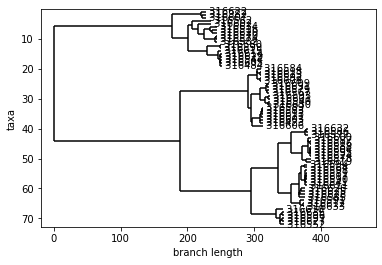

teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

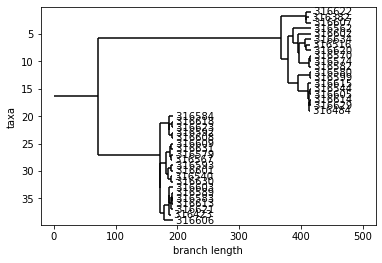

teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

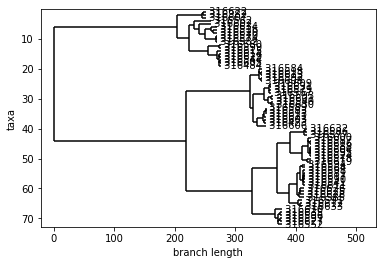

teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

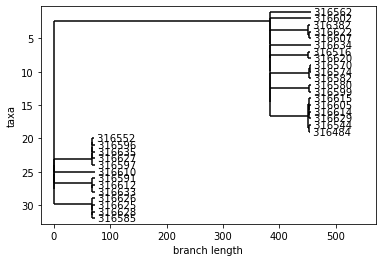

teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

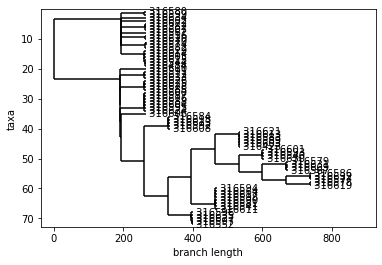

teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%RecencyProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

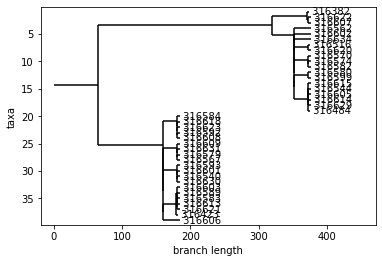

teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

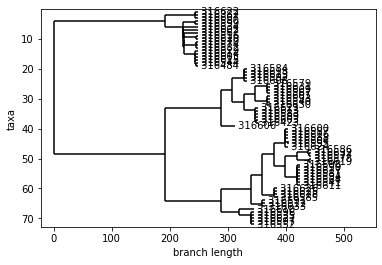

teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%1024+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

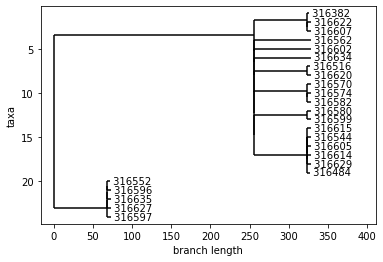

teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

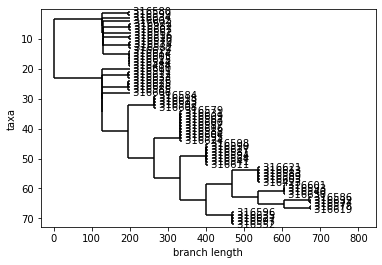

teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%256+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

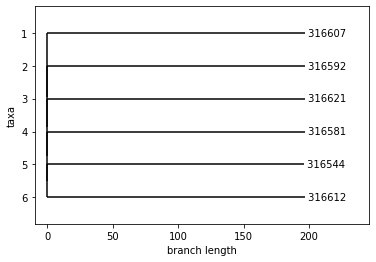

teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=nj+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

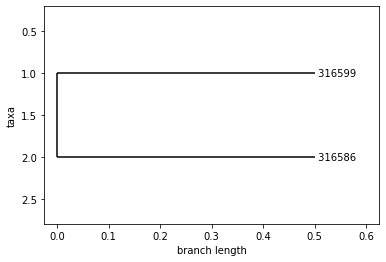

teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.pdf
teeplots/algorithm=upgma+treatment=differentia%8~policy%TaperedDepthProportionalResolution~target%64+viz=draw+ext=.png


<Figure size 432x288 with 0 Axes>

In [16]:
for (treatment, algorithm), tree in trees.items():
    tp.tee(
        Phylo.draw,
        tree,
        label_func=lambda node: None if 'Inner' in str(node) else str(node),
        teeplot_outattrs={
            'algorithm' : algorithm,
            'treatment' : kn.demote(treatment),
        },
    )
    plt.show()


In [17]:
alife_dataframes = {
    (treatment, algorithm): apc.biopython_tree_to_alife_dataframe(tree)
    for (treatment, algorithm), tree in trees.items()
}
for (treatment, algorithm), df in alife_dataframes.items():
    df['Treatment'] = treatment
    df['Algorithm'] = algorithm


In [18]:
res_df = pd.concat(alife_dataframes.values()).reset_index()


In [19]:
res_df


,index,id,ancestor_list,origin_time,branch_length,name,Treatment,Algorithm
0,0,0,[None],4736.0,71.000000,Inner38,differentia=1+policy=RecencyProportionalResolu...,nj
1,1,1,[0],4928.0,247.000000,Inner18,differentia=1+policy=RecencyProportionalResolu...,nj
2,2,2,[1],4995.0,44.000000,Inner2,differentia=1+policy=RecencyProportionalResolu...,nj
3,3,3,[2],4995.0,3.000000,Inner1,differentia=1+policy=RecencyProportionalResolu...,nj
4,4,4,[3],5001.0,6.500000,316622,differentia=1+policy=RecencyProportionalResolu...,nj
...,...,...,...,...,...,...,...,...
3323,9,9,[8],5000.0,196.060185,316544,differentia=8+policy=TaperedDepthProportionalR...,nj
3324,10,10,[8],5001.0,196.939815,316612,differentia=8+policy=TaperedDepthProportionalR...,nj
3325,0,0,[None],4736.0,0.000000,Inner2,differentia=8+policy=TaperedDepthProportionalR...,upgma
3326,1,1,[0],5001.0,0.500000,316599,differentia=8+policy=TaperedDepthProportionalR...,upgma


In [20]:
nbm.print_dataframe_synopsis(res_df)


digest: 4f461f246a4a5f568e15d2045d906922bd61740053a0a115f108b46f01a8b5af
manifest:
  Algorithm: '     2#    ex., nj'
  Treatment: '     18#   ex., differentia=1+policy=RecencyProportionalResolution+target=1024'
  ancestor_list: ' 138#  ex., [None]'
  branch_length: ' 721#  ex., 71.0'
  id: '            143#  ex., 0'
  index: '         143#  ex., 0'
  name: '          143#  ex., Inner38'
  origin_time: '   12#   ex., 4736.0'
num cols: 8
num cols all na: 0
num cols any na: 0
num na: 0
num rows: 3328
num rows all na: 0
num rows any na: 0
size: 1M



In [21]:
res_df.to_csv(
    f'a=reconstructed_phylogenies+source={kn.unpack(data_filename)["source"]}',
    compression='gzip',
)
